In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

!pip install openpyxl

In [3]:
data = pd.read_excel("data/ESG_raw_data_07_02.xlsx")

In [4]:
variables = ["scope_1", "scope_2", "scope_3", "waste_production",
             "waste_recycling", "water_consumption", "water_withdrawal",
             "energy_consumption", "hours_of_training", "independent_board_members_percentage",
             "legal_costs_paid_for_controversies", "ceo_compensation", "gender_pay_gap"]

variables_env =  ["scope_1", "scope_2", "scope_3", "waste_production",
             "waste_recycling", "water_consumption", "water_withdrawal",
             "energy_consumption"]

In [9]:
def isnan(num) :
    if num != num : 
        return True
    else :
        return False

def isntnan(num) :
    return bool(1 - int(isnan(num)))

def nanin(col) :
    for x in col :
        if isnan(x) :
            return True
    return False

# Un peu de Statdesc pour commencer

# Manque d'information et industries polluantes

On étudie la relation entre le manque d'information sur le "gender_pay_gap" et le fait qu'une industrie soit particulièrement polluante ou non, i.e si son "scope_1" moyen est élevé.

Pour commencer, je vais "normaliser" toutes les variables quantitatives par le nombre d'employés dans l'entreprise, afin que ces grandeurs puissent être comparées. Il est important de noter que je ne renomme pas ces variables.

In [6]:
data["scope_1"].head(5)

0    47430.0
1    52730.0
2    57440.0
3    49100.0
4    44700.0
Name: scope_1, dtype: float64

In [7]:
df = data
for x in variables_env :
    df[x] = df[x]/df['employees']

In [8]:
df["scope_1"].head(5)

0    0.322653
1    0.384891
2    0.435152
3    0.735030
4    0.565823
Name: scope_1, dtype: float64

On calcule alors les moyennes de données manquantes pour le "gender_pay_gap" et pour le "scope_1" par industrie.

In [10]:
missing_mean = df.groupby('primary_industry')['gender_pay_gap'].apply(lambda x: x.isnull().mean())
scope_1_mean = df.groupby('primary_industry')['scope_1'].mean()

In [89]:
scope_1_mean = scope_1_mean.dropna()
print(scope_1_mean.sort_values())
scope_1_mean_log = np.log(scope_1_mean)

primary_industry
Insurance Brokers                                     0.123478
Diversified Capital Markets                           0.210797
Systems Software                                      0.220121
Asset Management and Custody Banks                    0.253842
Apparel Retail                                        0.377051
                                                      ...     
Independent Power Producers and Energy Traders     5056.270213
Gold                                               7292.832339
Marine                                            12240.532480
Oil and Gas Storage and Transportation            13145.662761
Electric Utilities                                15354.066107
Name: scope_1, Length: 151, dtype: float64


Et on plot tout ça.

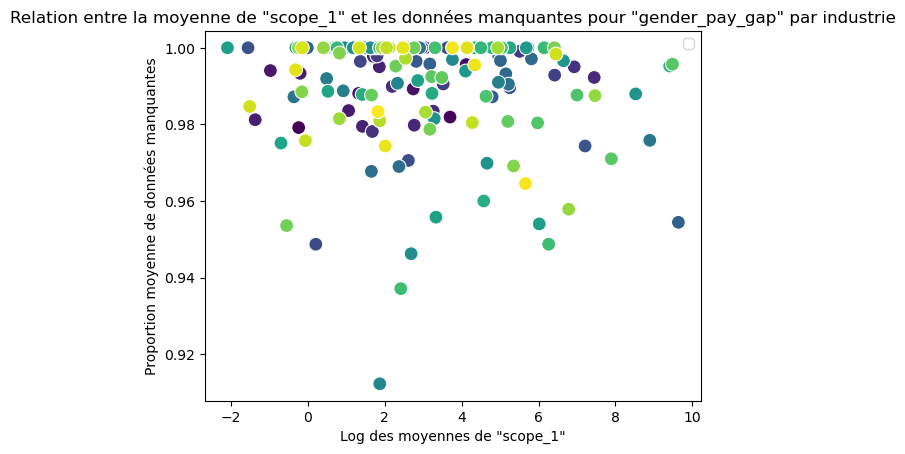

In [91]:
sns.scatterplot(x = scope_1_mean_log, y = missing_mean, hue = missing_mean.index, palette = 'viridis', s = 100)
plt.xlabel('Log des moyennes de "scope_1"')
plt.ylabel('Proportion moyenne de données manquantes')
plt.title('Relation entre la moyenne de "scope_1" et les données manquantes pour "gender_pay_gap" par industrie')
plt.legend('')
#plt.ylim((-10, 2000))
plt.show()

On peut alors effectuer des régressions, on va contrôler sur la région et sur l'année. On en effectue deux : une simple et une avec le "scope_1" en log. Ces régressions sont faites sur chaque entreprise, avec en $Y$ une variable binaire : le fait d'avoir ou non la donnée sur le "gender_pay_gap" et en co-variables : le "scope_1" de l'entreprise (normalisé par son nombre d'employés), la région, l'année. 

In [92]:
df2 = df

df2['missing'] = df2['gender_pay_gap'].isnull().astype(float)
df2 = df2.dropna(subset=['scope_1'])
df2['scope_1_log'] = np.log(df2['scope_1'])

# Régressions linéaires avec contrôle sur la région et l'année
X1 = df2[['scope_1', 'region', 'year', 'primary_industry']]
X1 = pd.get_dummies(X1, columns=['region', 'year', 'primary_industry'], drop_first=True, dtype=float)
X1 = sm.add_constant(X1)

X2 = df2[['scope_1_log', 'region', 'year', 'primary_industry']]
X2 = pd.get_dummies(X2, columns=['region', 'year', 'primary_industry'], drop_first=True, dtype=float)
X2 = sm.add_constant(X2)

y1 = df2['missing']

model1 = sm.OLS(y1, X1).fit()

# Pour le log, on doit filtrer les valeurs Nan car il y avait des "scope_1" égaux à 0
mask = ~X2.isin([np.nan, np.inf, -np.inf]).any(axis=1)
X2 = X2[mask]
y2 = df2['missing'][mask]
model2 = sm.OLS(y2, X2).fit()

print(model1.summary())
print(model2.summary())

/opt/mamba/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_2885/133898400.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['scope_1_log'] = np.log(df2['scope_1'])


                            OLS Regression Results                            
Dep. Variable:                missing   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     6.735
Date:                Mon, 12 Feb 2024   Prob (F-statistic):          1.67e-125
Time:                        10:21:43   Log-Likelihood:                 3548.9
No. Observations:               10705   AIC:                            -6782.
Df Residuals:                   10547   BIC:                            -5632.
Df Model:                         157                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

# Lien entre "rangs" au sein d'une même industrie

On va regarder si on peut mettre en évidence un lien entre être bon en "gender_pay_gap" et être bon en "scope_1" au sein d'une même industrie. Pour cela, on va classer chaque entreprise au sein de son secteur : premièrement en fonction du "gender_pay_gap" et deuxièmement en fonction de ses émissions dans le scope le plus pertinent pour son secteur. Ce scope pertinent sera pris comme le scope où les émissions moyennes du secteur sont les plus importantes.

In [65]:
sector_means = df.groupby('primary_industry').agg({'scope_1': 'mean', 'scope_2': 'mean', 'scope_3': 'mean'})
most_emitting_scope = sector_means.idxmax(axis=1)

nan_industries = most_emitting_scope.isna()
most_emitting_scope = most_emitting_scope.dropna()

print(most_emitting_scope)

primary_industry
Advertising                            scope_3
Aerospace and Defense                  scope_3
Agricultural Products                  scope_3
Agricultural and Farm Machinery        scope_3
Air Freight and Logistics              scope_1
                                        ...   
Tobacco                                scope_3
Trading Companies and Distributors     scope_3
Trucking                               scope_3
Water Utilities                        scope_1
Wireless Telecommunication Services    scope_3
Length: 151, dtype: object


/tmp/ipykernel_2885/369837432.py:2: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  most_emitting_scope = sector_means.idxmax(axis=1)


In [82]:
df3 = df

# On enlève toutes les entreprises venant d'un secteur où l'on a pas pu déterminer le "most_emitting_scope"
def nan_industry(row) :
    return nan_industries[row["primary_industry"]]

df3["nan_industry"] = df3.apply(nan_industry, axis = 1)
idx = df3.loc[df3["nan_industry"] == True].index.to_list()
df3 = df3.drop(index = idx)
df3 = df3.drop(columns = ["nan_industry"])

In [84]:
def most_emitting_scope_function(row) :
    return row[most_emitting_scope[row['primary_industry']]]

df3['most_emitting_scope'] = df3.apply(most_emitting_scope_function, axis = 1)
df3 = df3.dropna(subset=['most_emitting_scope'])
df3.head(5)

,company_id,year,company_name,ticker,LEI,isin,Business Desc.,region,hq_country,primary_industry,...,water_withdrawal,energy_consumption,hours_of_training,independent_board_members_percentage,legal_costs_paid_for_controversies,ceo_compensation,gender_pay_gap,missing,scope_1_log,most_emitting_scope
0,c67ee84d-5cf4-4cd0-85b9-027ad082748f,2020,Apple Inc.,NasdaqGS:AAPL,HWUPKR0MPOU8FGXBT394,US0378331005,"Apple Inc. designs, manufactures, and markets ...",United States and Canada,United States,"Technology Hardware, Storage and Peripherals",...,33.163265,20.538571,NaN,0.008571,0.00,14769259.0,NaN,1.0,-1.131178,153.401361
1,c67ee84d-5cf4-4cd0-85b9-027ad082748f,2019,Apple Inc.,NasdaqGS:AAPL,HWUPKR0MPOU8FGXBT394,US0378331005,"Apple Inc. designs, manufactures, and markets ...",United States and Canada,United States,"Technology Hardware, Storage and Peripherals",...,36.441053,21.092555,NaN,0.008571,1.85,11555466.0,NaN,1.0,-0.954796,182.335766
2,c67ee84d-5cf4-4cd0-85b9-027ad082748f,2018,Apple Inc.,NasdaqGS:AAPL,HWUPKR0MPOU8FGXBT394,US0378331005,"Apple Inc. designs, manufactures, and markets ...",United States and Canada,United States,"Technology Hardware, Storage and Peripherals",...,37.304867,20.276212,NaN,0.008750,NaN,15682219.0,NaN,1.0,-0.832061,189.924242
3,9ea5e71e-33ac-4916-9c58-50ce9fa54abe,2020,Saudi Arabian Oil Company,SASE:2222,5586006WD91QHB7J4X50,SA14TG012N13,Saudi Arabian Oil Company operates as an integ...,Africa / Middle East,Saudi Arabia,Integrated Oil and Gas,...,541.167665,2238.982036,NaN,0.454540,0.00,NaN,NaN,1.0,-0.307844,28097.683982
6,0fc16315-00da-4223-9cd5-0b09f6274aeb,2020,Microsoft Corporation,NasdaqGS:MSFT,INR2EJN1ERAN0W5ZP974,US5949181045,"Microsoft Corporation develops, licenses, and ...",United States and Canada,United States,Systems Software,...,46.043442,65.995092,NaN,0.916670,0.00,NaN,NaN,1.0,-0.322218,66.366871


/tmp/ipykernel_2885/2897180220.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'rank_emissions', y = 'rank_gender', data = df3, palette='viridis', s=100)


Text(0.5, 1.0, "Relation entre rang d'émissions et de gender_pay_gap au sein d'une même industrie")

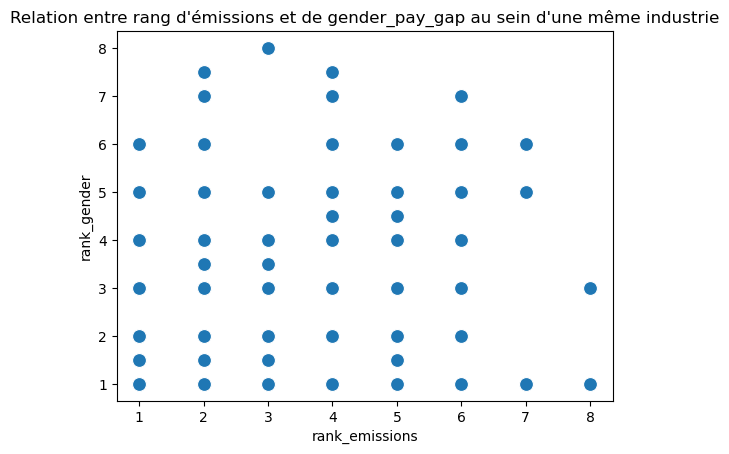

In [93]:
df3['rank_gender'] = df3.groupby(['primary_industry', 'year'])['gender_pay_gap'].rank(ascending=False)
df3['rank_emissions'] = df3.groupby(['primary_industry', 'year'])['most_emitting_scope'].rank(ascending=False)
df3 = df3.dropna(subset = ['rank_gender', 'rank_emissions'])

sns.scatterplot(x = 'rank_emissions', y = 'rank_gender', data = df3, palette='viridis', s=100)
plt.title("Relation entre rang d'émissions et de gender_pay_gap au sein d'une même industrie")

On effectue une régression en contrôlant de nouveau sur la région et l'année.

In [97]:
# Régressions linéaires avec contrôle sur la région et l'année
X = df3[['rank_emissions', 'region', 'year', 'primary_industry']]
X = pd.get_dummies(X, columns=['region', 'year', 'primary_industry'], drop_first=True, dtype=float)
X = sm.add_constant(X)

y = df3['rank_gender']

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            rank_gender   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     2.045
Date:                Mon, 12 Feb 2024   Prob (F-statistic):           1.39e-05
Time:                        10:52:19   Log-Likelihood:                -460.24
No. Observations:                 303   AIC:                             1100.
Df Residuals:                     213   BIC:                             1435.
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [101]:
!pip install FixedEffectModel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 10.4 MB/s eta 0:00:00


In [102]:
from fixedeffect.fe import fixedeffect

In [107]:
y = np.array(df3['rank_gender'])

exog_x = df3[['rank_emissions', 'region', 'primary_industry']]
#exog_x = pd.get_dummies(exog_x, columns=['region', 'primary_industry'], drop_first=True, dtype=float)

category = ['company_id','year']
cluster = ['company_id','year']

model_fe = fixedeffect(data_df = df3,
                      dependent = y,
                      exog_x = exog_x,
                      category = category,
                      cluster = cluster)

result = model_fe.fit()
result.summary()

/opt/mamba/lib/python3.11/site-packages/fixedeffect/utils/DemeanDataframe.py:30: UserWarning: panel is unbalanced
  warnings.warn('panel is unbalanced')


TypeError: agg function failed [how->mean,dtype->object]